# Precise Inpainting with Segment Anything, DALLE-2 and Stable Diffusion
<img src="../media/advanced-inpainting-small.png" alt="drawing" style="width:1200px;"/>

This notebook guides you through the process of image inpainting, i.e., replacing an object in an image based on a text description. Here is a breakdown of the steps we'll be taking:

1. **Source Image Selection:** Choose the image that you wish to modify through inpainting.

2. **Object Identification & Segmentation:** Mark the object that you want to replace by providing a few coordinates of the region. Following this, you'll choose a segmentation mask, suggested by the 'Segment Anything Model' (SAM).

3. **Inpainting:** We will employ either DALLE-2 or Stable Diffusion to inpaint the masked region with a new object that you define using a text prompt.

*Important:* Stable Diffusion offers numerous options to finely tune the resulting image. We highly recommend referring to the [Text-guided Image Inpainting](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/inpaint) documentation for a more detailed understanding.


## Setup

In [ ]:
#%pip install torch torchvision torchaudio
# %pip install git+https://github.com/facebookresearch/segment-anything.git
# %pip install opencv-python pycocotools matplotlib onnxruntime onnx

# note depending on your setup, the following commands might be necessary to import cv2:
# sudo apt-get update
# sudo apt-get install ffmpeg libsm6

In [1]:
import glob
import os
import re
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openai
import plotly.graph_objects as go
from dotenv import load_dotenv
from PIL import Image
import torch

sys.path.insert(0, '..')

from segment_anything import sam_model_registry, SamPredictor
from utils import show_images

In [2]:
# read API key of original OpenAI service from .enf file
load_dotenv('../.env')
openai.api_key = os.getenv('OPENAI_API_KEY')

# Uncomment and run once to download the SAM model
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# initialize SAM model
sam_model_filepath = "./sam_vit_h_4b8939.pth"
sam = sam_model_registry["default"](checkpoint=sam_model_filepath)

In [3]:
def show_mask(mask, ax):
    """ Display segmentation mask """
    color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    """ Display coordinates for mask creation """
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )

## Load Source Image

In [4]:
source_img = './source/no-smile-1024.png'
image = Image.open(source_img)

height = image.height
width = image.width

## Select Coordinates for Mask Generation

In [ ]:
# Convert image to numpy array
np_image = np.array(image)

# Create a figure using Plotly
fig = go.Figure(data=go.Image(z=np_image))
fig.update_layout(width=width, height=height)

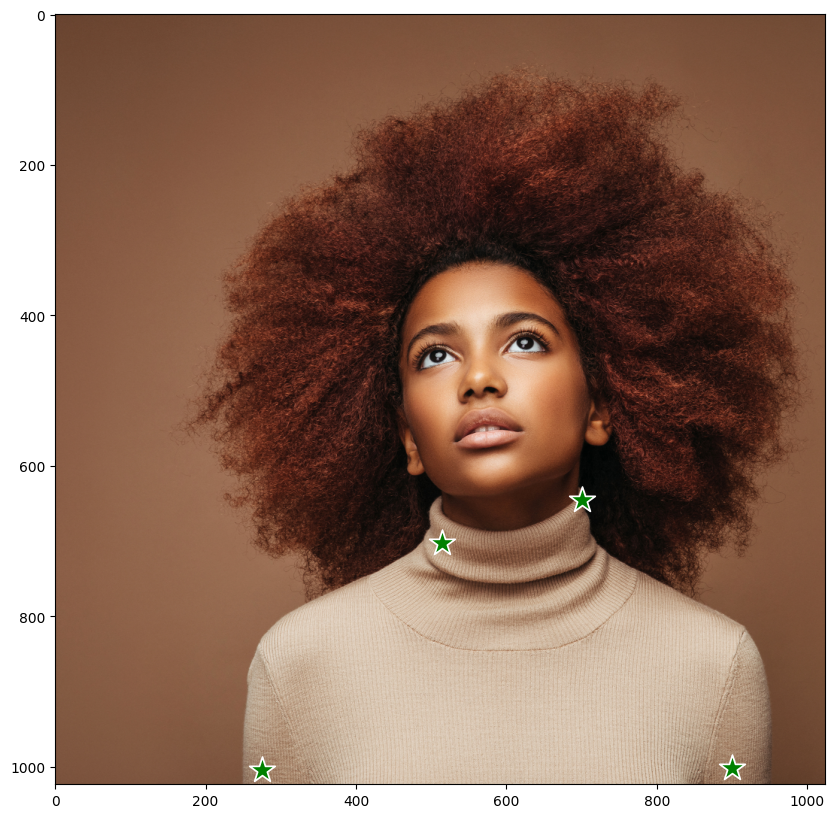

In [9]:
# Enter any number of x,y coordinates for the mask:   
input_points = np.array([[515, 702], [700, 645], [275, 1005], [900, 1002]])
input_labels = np.ones(input_points.shape[0], dtype=int)

# Load chosen image using opencv
image = cv2.imread(source_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_points, input_labels, plt.gca())
plt.axis("on")
plt.show()

In [10]:
# Initiate predictor with Segment Anything model
predictor = SamPredictor(sam)
predictor.set_image(image)

# Use the predictor to gather masks for the point we clicked
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)

# Check the shape - should be three masks of the same dimensions as our image
masks.shape

(3, 1024, 1024)

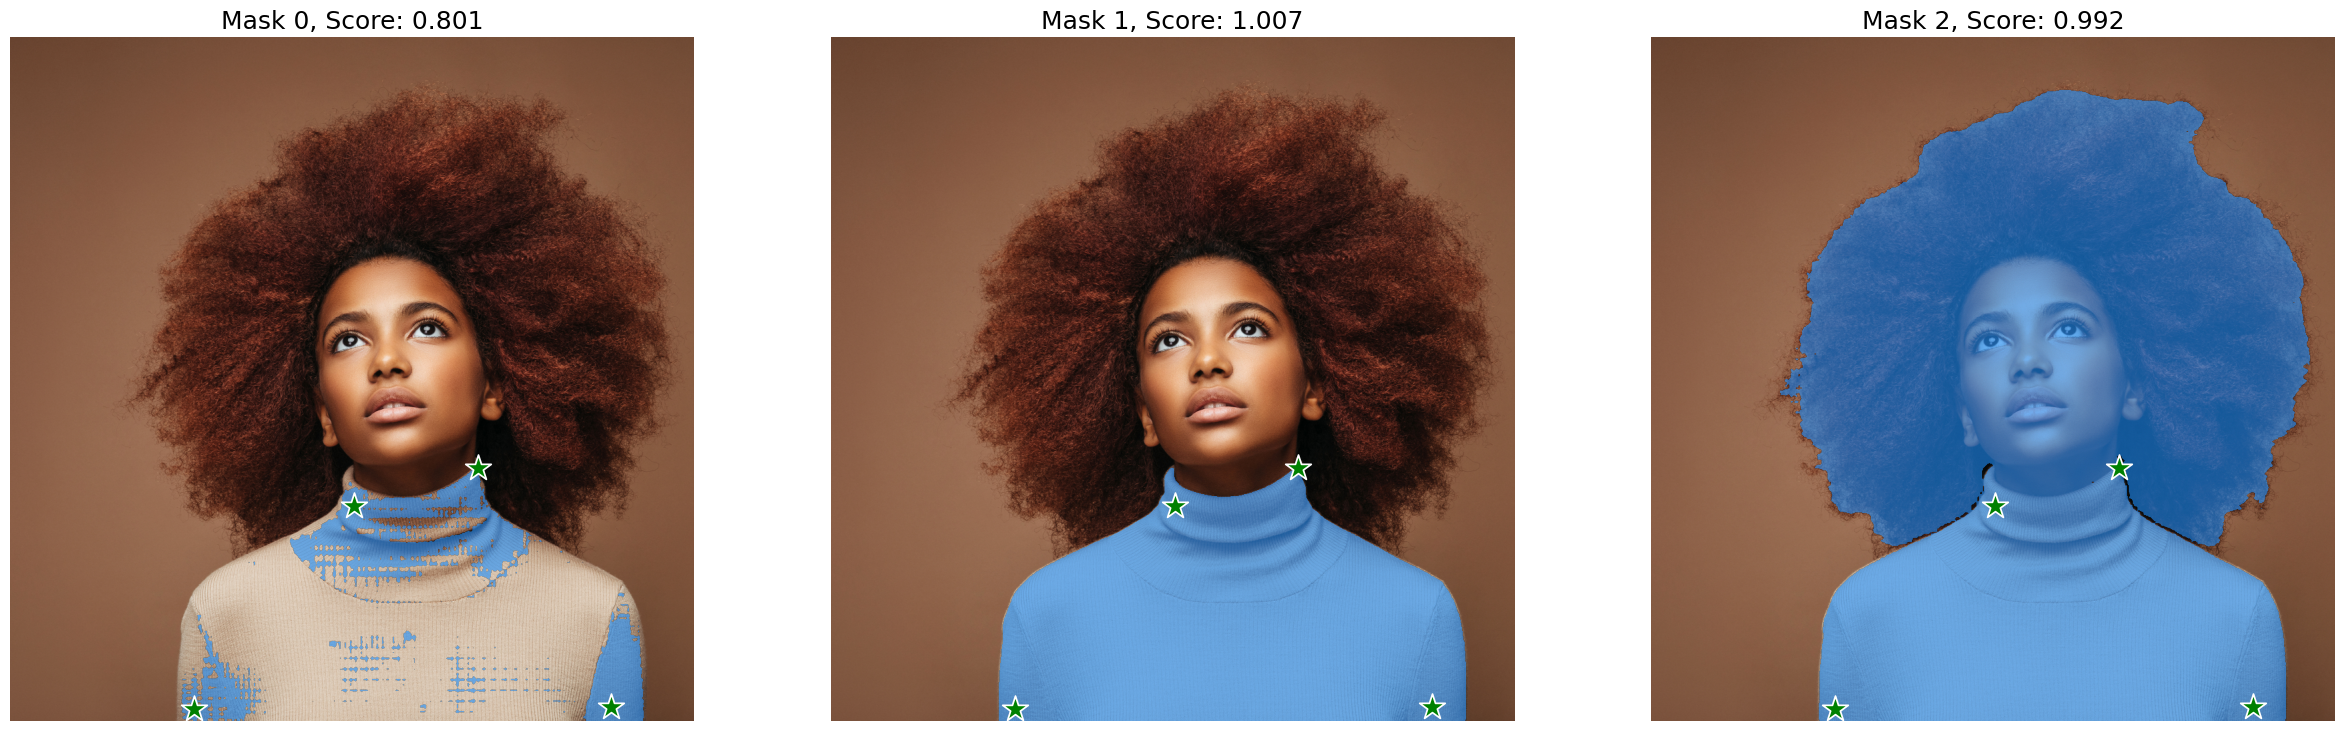

In [11]:
n_masks = len(masks)
fig = plt.figure(figsize=(10*n_masks, 10))  # adjust the total width according to the number of masks

for i, (mask, score) in enumerate(zip(masks, scores)):
    ax = fig.add_subplot(1, n_masks, i+1)  # Create 1 row of n_masks columns of subplots
    ax.imshow(image)
    show_mask(mask, ax)
    show_points(input_points, input_labels, ax)
    ax.set_title(f"Mask {i}, Score: {score:.3f}", fontsize=18)
    ax.axis("off")

plt.show()

In [12]:
# Choose which mask you'd like to use (zero indexed)
chosen_mask = masks[1]

# We'll now reverse the mask so that it is clear and everything else is white
chosen_mask = chosen_mask.astype("uint8")
chosen_mask[chosen_mask != 0] = 255
chosen_mask[chosen_mask == 0] = 1
chosen_mask[chosen_mask == 255] = 0
chosen_mask[chosen_mask == 1] = 255

# create a base blank mask
mask = Image.new("RGBA", (width, height), (0, 0, 0, 1))  # create an opaque image mask

# Convert mask back to pixels to add our mask replacing the third dimension
pix = np.array(mask)
pix[:, :, 3] = chosen_mask

# Convert pixels back to an RGBA image and display
new_mask = Image.fromarray(pix, "RGBA")

# save mask for re-use for our edit
mask_image = './mask.png'
new_mask.save(mask_image)

## Inpaint with DALLE-2

In [13]:
response = openai.Image.create_edit(
  image=open(source_img, "rb"),
  mask=open(mask_image, "rb"),
  prompt="women polo-shirt, detailed, photorealistic, professional fashion photo shooting, fashion magazine",
  n=6,
  size="1024x1024"
)
images = [image['url'] for image in response['data']]

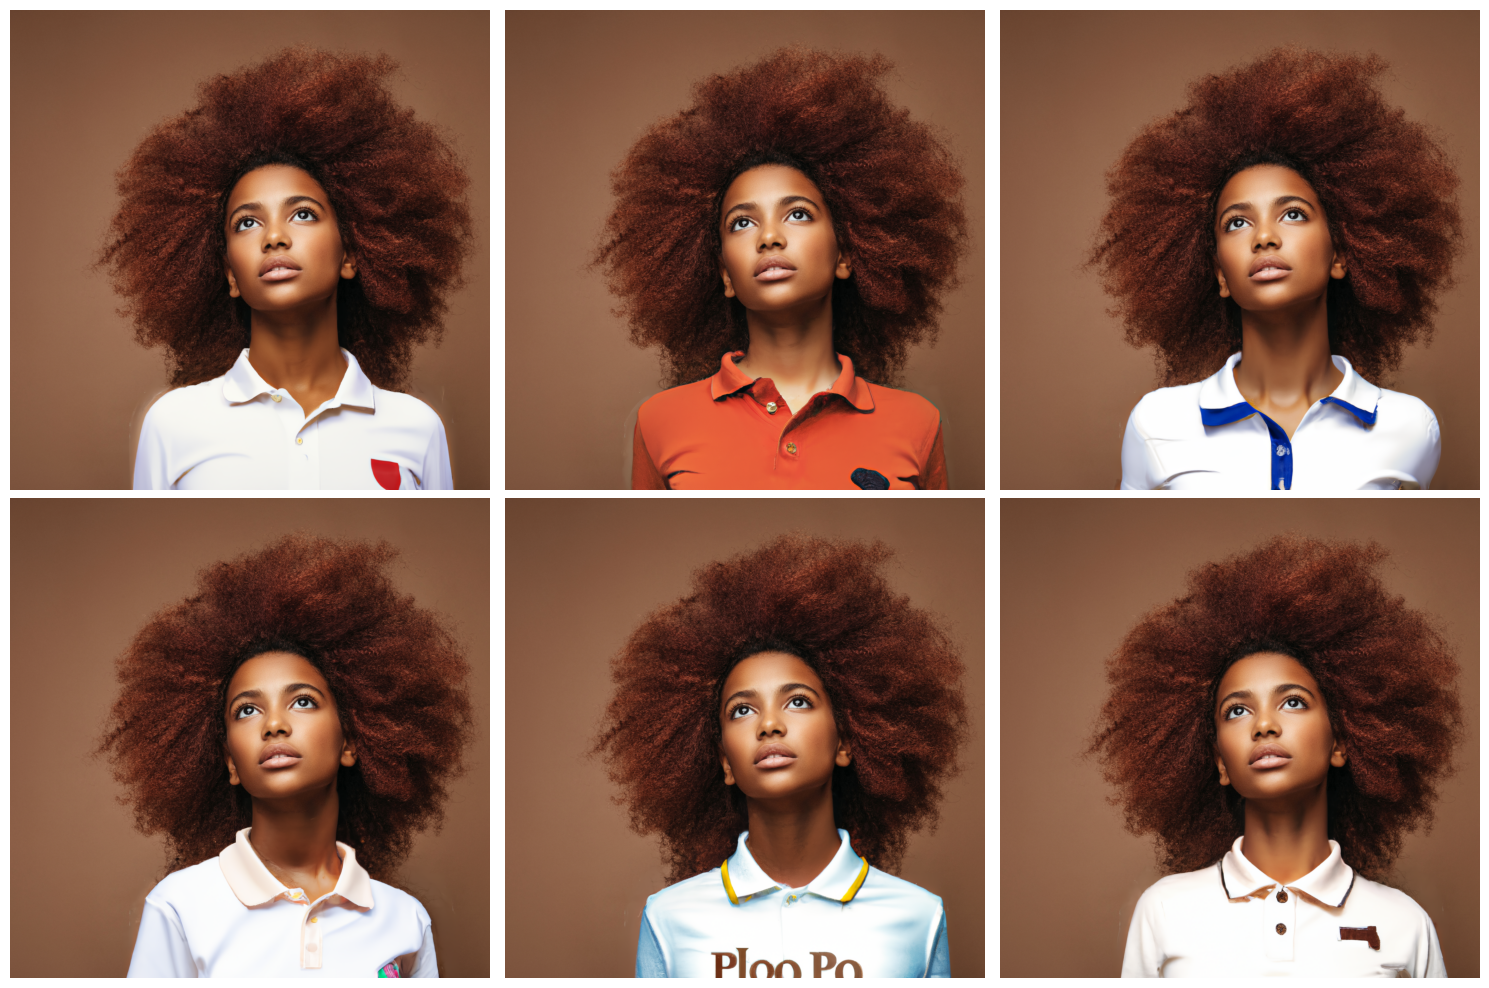

In [14]:
show_images(images, cols=3, savedir='./results/no-smile/')

## Inpaint with Stable Diffusion

In [15]:
from diffusers import StableDiffusionInpaintPipeline
from PIL import ImageOps

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting", # options: runwayml/stable-diffusion-inpainting, stabilityai/stable-diffusion-2-inpainting
    revision="fp16",
    torch_dtype=torch.float16,
).to('cuda')


unet/diffusion_pytorch_model.safetensors not found
/home/codespace/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning:

The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.



In [16]:
src_image = Image.open(source_img)
mask_image = Image.open('./mask.png')
inv_mask = mask_image.split()[3]
mask = ImageOps.invert(inv_mask)

prompt = "women summer polo-shirt, detailed, photorealistic, professional fashion photo shooting, fashion magazine"
negative_prompt = 'deformed, disfigured, underexposed, overexposed'

result = pipe(prompt=prompt,
             negative_prompt= negative_prompt, 
             image=src_image,
             mask_image=mask,
             height = height,
             width = width,
             num_images_per_prompt=6,
             )

  0%|          | 0/50 [00:00<?, ?it/s]

In [17]:
savedir = './results/sd/no-smile'
os.makedirs(savedir, exist_ok=True)

files = glob.glob(f'{savedir}/*')
for f in files:
    os.remove(f)

# Get all png files in the folder
files = glob.glob(f'{savedir}/*.png')

# Extract the numeric parts from the filenames
numbers = [int(re.findall(r'(\d+)', file)[0]) for file in files if re.findall(r'(\d+)', file)]

# Return the highest number, or 0 if no files exist
idx = max(numbers) if numbers else 0

images = []
for image in result.images:
    image_path = os.path.join(savedir, f'{idx:003}.png')
    image.save(image_path)
    images.append(image_path)
    idx += 1

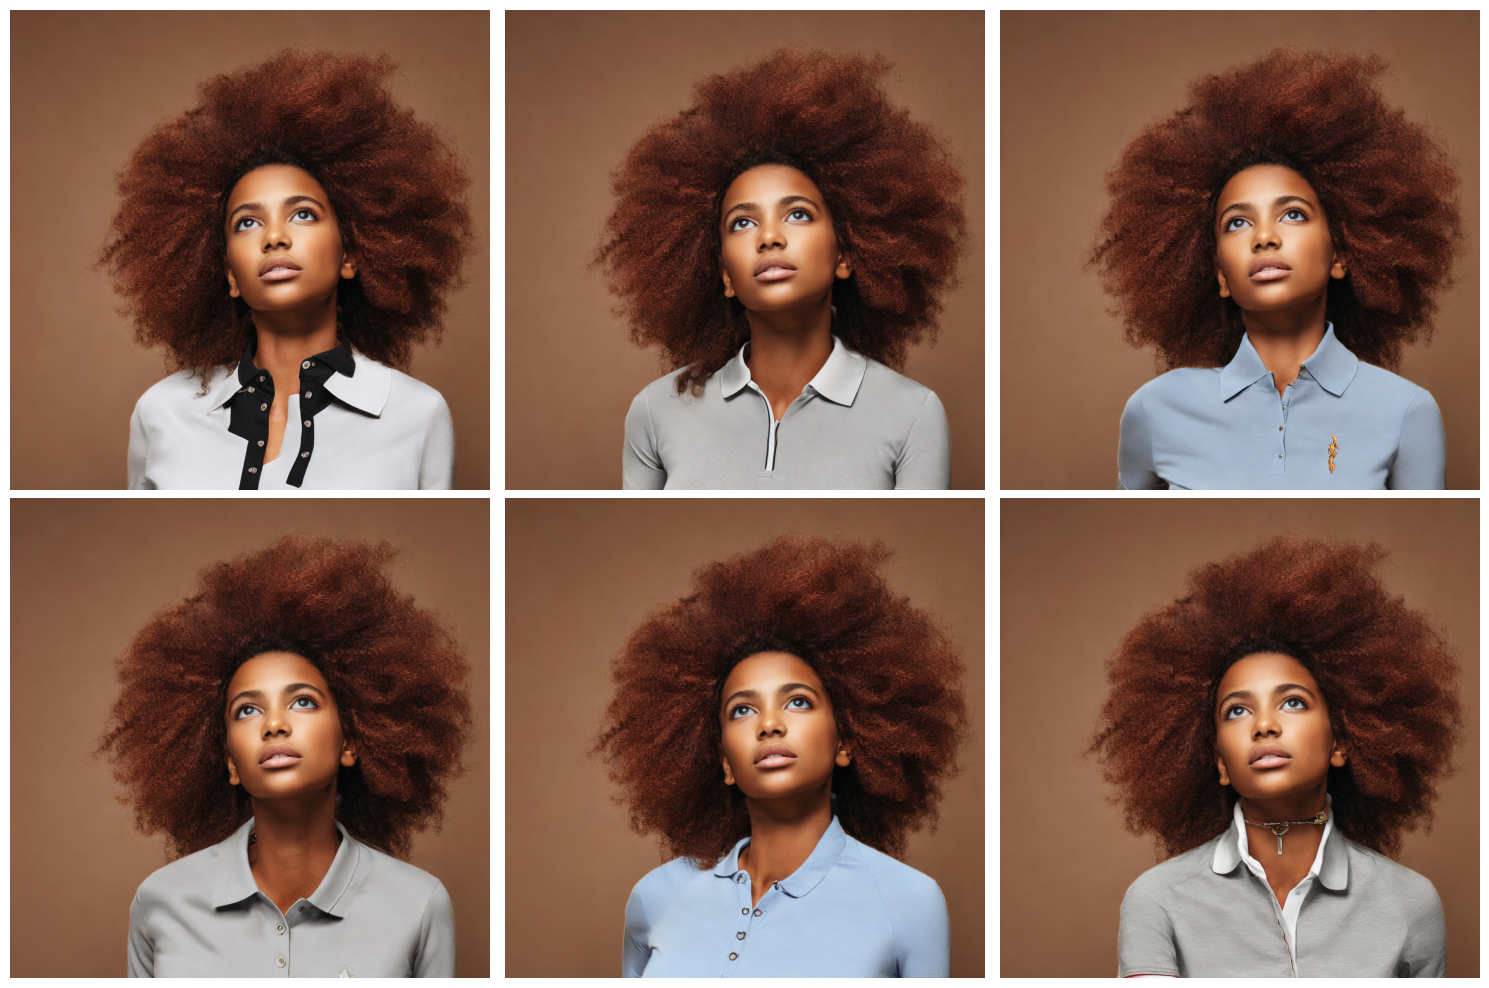

In [18]:
show_images(images, source='local', cols=3)

## Create a Video from the Images

In [ ]:
def create_video(image_folder, video_name, fps, blend_frames=10):
    """
    Create a video from a folder of images with cross-fading effect.

    Parameters:
    - image_folder: str, path to the folder containing the images
    - video_name: str, name of the output video file (including .mp4 extension)
    - fps: int, frames per second 
    - blend_frames: int, number of frames for blending effect
    """
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images.sort()

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for i in range(len(images) - 1):
        image1 = cv2.imread(os.path.join(image_folder, images[i]))
        image2 = cv2.imread(os.path.join(image_folder, images[i + 1]))

        # Create a transition from image1 to image2 over blend_frames
        for j in range(blend_frames):
            alpha = j / blend_frames  # Calculate the weight of the second image
            blended = cv2.addWeighted(image1, 1 - alpha, image2, alpha, 0)  # Blend the two images
            video.write(np.uint8(blended))

    # Write the last frame
    video.write(cv2.imread(os.path.join(image_folder, images[-1])))

    cv2.destroyAllWindows()
    video.release()

# Usage
# create_video('./results/smile', 'output.mp4', 3, blend_frames=1)
